### Описание задачи

Задачу information extraction можно представить как задачу классификации для фрагментов текста. В нашем случае мы можем выбирать наиболее подходящее предложение из текста из метода predict_proba

Для этого необходимо простроить две модели под каждый label (обеспечение гарантийных обязательств и обеспечение исполнения контракта)


В исходных данных в data preprocessing я увидел очевидный дисбаланс в классификации. Для "обеспечения гарантийных обязательств" доля ответов где мы не могли выбрать подходящее предложение составляла прктически 38%, когда для "обепечения исполнения контракта" таких случаев было всего 4 из 1000.

Поэтому для построения модели "обеспечения гарантийных обязательств" мы введём пороговое значение, выше которого наше предложение будет относиться к выбранному классу, а ниже нет. Такой коэффициент нужно будет подбирать для каждой модели. 

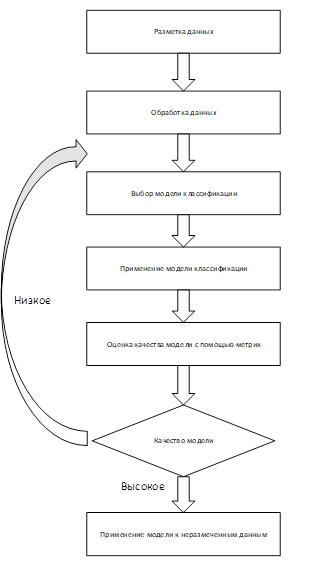

Решение в даном модуле основано на статье: https://telegra.ph/Pajplajn-dlya-sozdaniya-klassifikacii-tekstovoj-informacii-04-13
которая во многом помогла мне разобраться в задаче классификации текстовой информации. 

### Установки 

In [ ]:
!pip install navec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2023-04-18 16:39:43--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.4MB/s    in 3.3s    

2023-04-18 16:39:47 (15.5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 71.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=a7014b9745e5f4ae0a4a6ceee2c1193b86b8f010be87d55ab104acec270ace38
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


### Импорты

In [ ]:
from utils import (
    splitter, lemmatization, text_accuracy_score, 
    get_word_vectors_from_dataframe, choose_max_rate_sentence, 
    split_df_texts_by_sentences, lemmatize_splitted_df_sentences,
    get_sentence_vectors_from_lemmatized_text)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, roc_auc_score, classification_report, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from navec import Navec
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import joblib
import nltk

In [ ]:
path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Подготовка датасета

In [ ]:
with open('/content/contract_enforcement_lemmatized.pkl', 'rb') as fp:
  contract_enforcement = pickle.load(fp)

In [ ]:
with open('/content/garantee_enforcement_lemmatized.pkl', 'rb') as fp:
  garantee_enforcement = pickle.load(fp)
  

In [ ]:
with open('/content/nonetype_lemmatized.pkl', 'rb') as fp:
  nonetype = pickle.load(fp)

In [ ]:
def make_dataset(sample_list , target=None):
  # на входе принимает список предложений, возвращает pandas DataFrame.
  dataframe = pd.DataFrame({'text': ['']})
  for i, sentence in enumerate(sample_list):
    dataframe.at[i, 'text'] = sentence
  
  if target is not None:
    dataframe.loc[:, 'target'] = target
  
  return dataframe

In [ ]:
contract_enforcement = make_dataset(contract_enforcement, target=1)
len(contract_enforcement)

984

In [ ]:
garantee_enforcement = make_dataset(garantee_enforcement, target=1)
len(garantee_enforcement)

508

In [ ]:
nonetype_1000 = np.random.choice(nonetype, 1500, replace=False)
nonetype_1000 = make_dataset(nonetype_1000, target=0)
len(nonetype_1000)

<ipython-input-24-728f5751e013>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nonetype_1000 = np.random.choice(nonetype, 1500, replace=False)


1500

In [ ]:
# объединение датасетов из целевых предложений и нецелевых 
contract_enforcement = pd.concat([contract_enforcement, nonetype_1000], axis=0)
contract_enforcement.sample(frac=1)
contract_enforcement.reset_index(drop=True, inplace=True)

In [ ]:
# объединение датасетов из целевых предложений и нецелевых 
garantee_enforcement = pd.concat([garantee_enforcement, nonetype_1000], axis=0)
garantee_enforcement.sample(frac=1)
garantee_enforcement.reset_index(drop=True, inplace=True)


### Построение модели для "обеспечение исполнения контракта"

так как в data preprocessing мы уже разделили тексты в датасете на предложения и из них простроили списки лемм в них, можем использовать готовый датасет train_lemmatized для векторизации. 

In [ ]:
def search_best_estimator(model, param_grid, x, y):
    # на вход получает модель и словарь из параметров модели, с помощью GridSearchCV ищщеет лучшую модель и возвращает её 
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_jobs=-1,
        verbose=5
    )
    _ = gs.fit(x, y)
    return gs.best_estimator_

In [ ]:
def plot_confusion_matrix(y_test, y_preds, model):
    # на вход принимает таргет из валдационного датасета и наши предсказания и выводит матрицу ошибок
    fig, ax = plt.subplots(figsize=(10,8))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

Векторизуем слова с помощью word2vec используя navec_hudlit_v1_12B_500K_300d_100q.tar из https://github.com/natasha/navec?ysclid=lgi8rvqlyo416346758 и в качестве векторов предложений возьмём средние значения word2vec

In [ ]:
def get_word_vectors_from_dataframe(dataframe, navec):
  # принимает датафрейм с лемматизированными предложениями, возвращает векторы предложений 
  df = []
  for i in range(len(dataframe)):
    sentence = []
    for j in range(len(dataframe.loc[i, 'text'])):
      try:
        word_embending = navec[dataframe.loc[i, 'text'][j]].mean()
        sentence.append(word_embending)
      except:
        sentence.append(0)
    df.append(sentence)
  df = pd.DataFrame(df, dtype='float64')
  df['target'] = dataframe['target']
  df.fillna(0, inplace=True)
  return df
    

In [ ]:
contract_enforcement_vectorized = get_word_vectors_from_dataframe(contract_enforcement, navec)
contract_enforcement_vectorized.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,target
1288,0.013059,0.025184,-0.036867,-0.018133,-0.004451,-0.020056,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1045,0.025594,-0.021342,0.010874,-0.005698,-0.006649,0.007806,-0.037828,-0.000059,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016,0.000000,0.009430,0.000000,-0.017342,0.000000,0.000000,0.006401,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1683,-0.018133,-0.020056,-0.003795,-0.001652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2193,0.034563,-0.016679,0.008983,-0.015306,-0.006596,-0.000059,0.009632,0.003380,-0.019525,0.014812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
x, y = contract_enforcement_vectorized.drop(columns=['target']), contract_enforcement_vectorized['target'].values

model = RandomForestClassifier()

param_grid = {
"n_estimators": [i for i in range(400, 1000,50)],
"max_depth": [i for i in range(25, 101,25)],
"min_samples_split":[i for i in range(3,10,2)],
"min_samples_leaf": [2 ,3],
}
estimator = search_best_estimator(model, param_grid, x, y)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


In [ ]:
# Делим выборку на тренировочную и валидационную.
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

In [ ]:
estimator.fit(x_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=400)

In [ ]:
y_pred = estimator.predict(x_test)

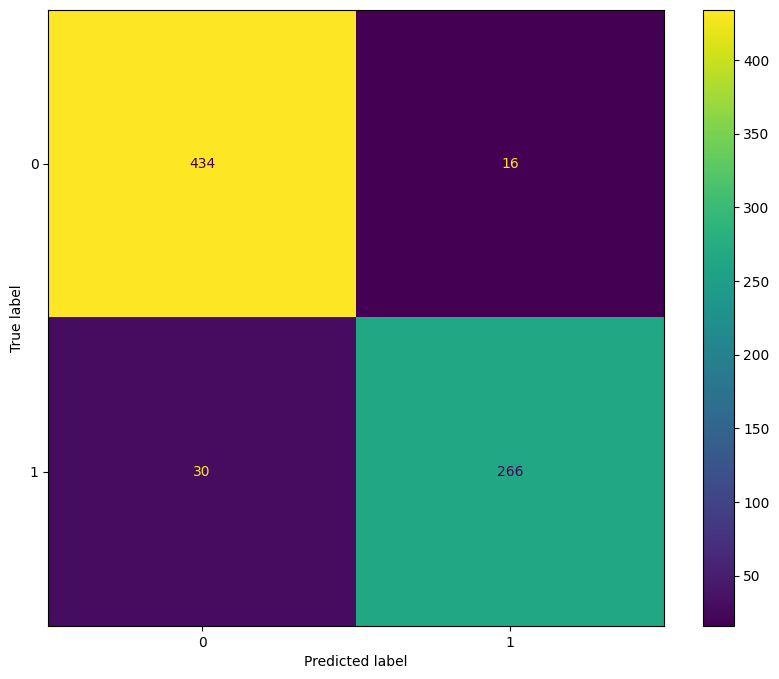

In [ ]:
plot_confusion_matrix(y_test, y_pred, estimator)

In [ ]:
f1_score(y_test, y_pred)

0.9204152249134949

In [ ]:
x, y = contract_enforcement_vectorized.drop(columns=['target']), contract_enforcement_vectorized['target'].values

In [ ]:
model = XGBClassifier()

param_grid = {
"n_estimators": [i for i in range(50, 1000,100)],
"max_depth": [i for i in range(25, 101,25)],
"min_samples_split":[i for i in range(3,10,2)],
"min_samples_leaf": [2 ,3],
}
estimator = search_best_estimator(model, param_grid, x, y)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
[18:05:52] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

In [ ]:
estimator.fit(x_train, y_train)


[18:06:02] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=3,
              missing=nan, monotone_constraints=None, n_estimators=850,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = estimator.predict(x_test)


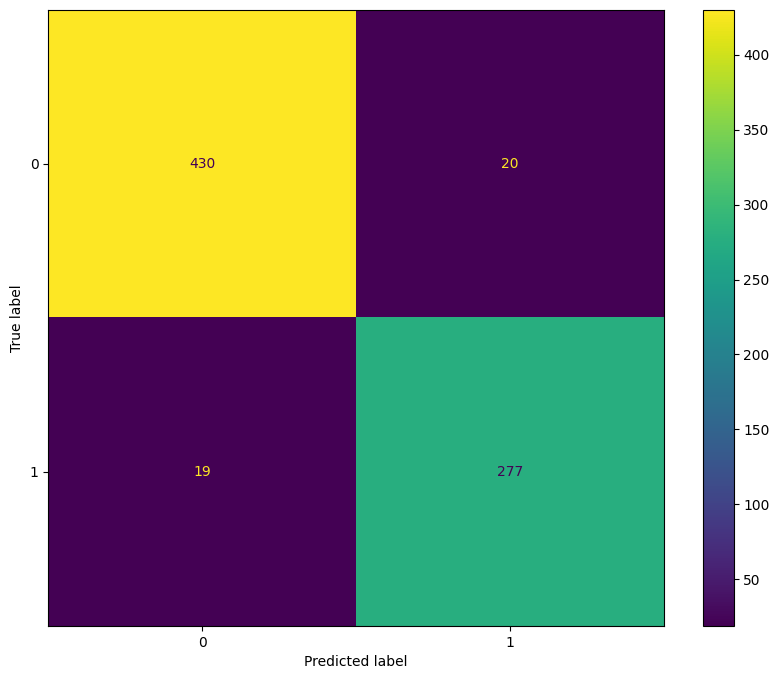

In [ ]:
plot_confusion_matrix(y_test, y_pred, estimator)


In [ ]:
f1_score(y_test, y_pred)

0.9342327150084317

In [ ]:
accuracy_score(y_test, y_pred)

0.9477211796246648

In [ ]:
x, y = contract_enforcement_vectorized.drop(columns=['target']), contract_enforcement_vectorized['target'].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)
contract_enforcement_model = XGBClassifier(
    max_depth=25,
    min_samples_leaf=2, 
    min_samples_split=3,
    n_estimators=150,
)
contract_enforcement_model.fit(x_train, y_train)
y_pred = contract_enforcement_model.predict(x_test)
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

[18:06:55] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



(0.936026936026936, 0.9490616621983914)

In [ ]:
# сохранение результатов
joblib.dump(contract_enforcement_model, 'contract_enforcement_xgb_model.joblib')

['contract_enforcement_xgb_model.joblib']

1 набор датасета nonetype:
f1 - 0.9865 

SetFit на 31 объекте выдаёт 0.9827

на 159 - 0.9986


2 набор 
f1 - 0.936 
модель убавила в качестве за счёт того, что мы используем болле похожие на реальные датасеты данные. В прошлом разбиении, где мы взяли в качестве nonetype - все предложения из текстов с нулевым таргетом, получалась хорошая метрика у модели, но на реальных данных по качеству разбиения на фрагменты 63% получалось попадать в 53% accuracy. т.е. на  реальных данных модель вела себя хуже. Связано это с тем, что в некоторых разбиениях присутствуют фрагменты с разницей в 1-2 слова. С новой выборкой для класса nonetype модель хоть и работает хуже, на реальных данных должна показать себя лучше. 

### Построение модели для "обеспечение гарантийных обязательств"

In [ ]:
garantee_enforcement_vectorized = get_word_vectors_from_dataframe(garantee_enforcement, navec)
garantee_enforcement_vectorized.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,target
442,-0.000241,-0.021342,0.010874,-0.012313,-0.013732,0.004740,0.017825,-0.026603,-0.015306,0.008983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1916,-0.005637,0.000518,0.003660,-0.003795,-0.001652,-0.010312,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
280,-0.026603,-0.021342,-0.012313,-0.013732,-0.006596,0.011202,0.019443,0.006672,-0.015306,-0.006596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1758,-0.020030,-0.021287,-0.000723,0.013816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
357,-0.026603,-0.021342,-0.012313,-0.013732,-0.005421,0.004189,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
x, y = garantee_enforcement_vectorized.drop(columns=['target']), garantee_enforcement_vectorized['target'].values

In [ ]:
model = XGBClassifier()

param_grid = {
"n_estimators": [i for i in range(50, 1000,100)],
"max_depth": [i for i in range(25, 101,25)],
"min_samples_split":[i for i in range(3,8,2)],
"min_samples_leaf": [2 ,3],
}
estimator = search_best_estimator(model, param_grid, x, y)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[18:37:25] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

In [ ]:
estimator.fit(x_train, y_train)

[18:37:27] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=3,
              missing=nan, monotone_constraints=None, n_estimators=350,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = estimator.predict(x_test)

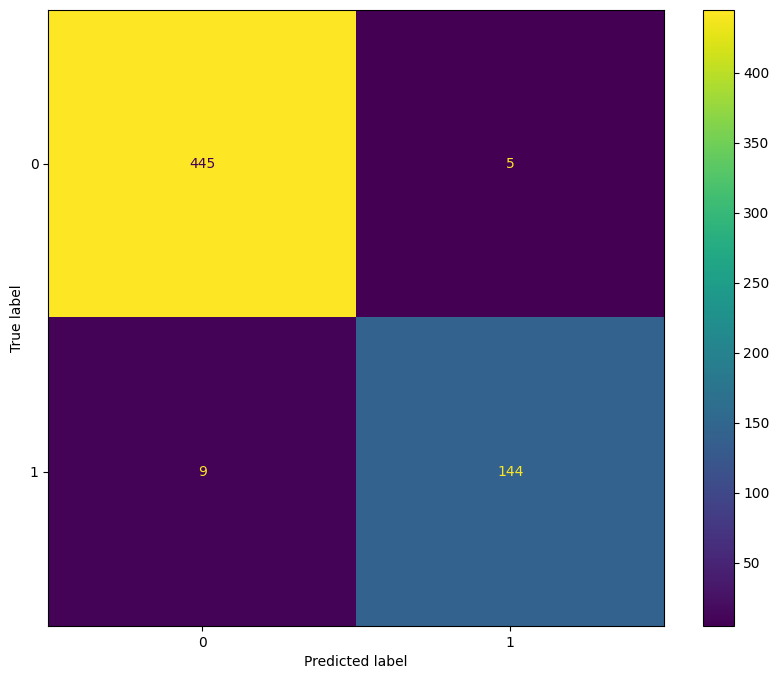

In [ ]:
plot_confusion_matrix(y_test, y_pred, estimator)

In [ ]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.9536423841059601, 0.9767827529021559)

In [ ]:
x, y = garantee_enforcement_vectorized.drop(columns=['target']), garantee_enforcement_vectorized['target'].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

garantee_enforcement_model = XGBClassifier(
    max_depth=25, 
    min_samples_leaf=2, 
    min_samples_split=3,
    n_estimators=350
)

garantee_enforcement_model.fit(x_train, y_train)
y_pred = garantee_enforcement_model.predict(x_test)
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

[18:43:31] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



(0.9536423841059601, 0.9767827529021559)

In [ ]:
# сохранение результатов
joblib.dump(garantee_enforcement_model, 'garantee_enforcement_xgb_model.joblib')

['garantee_enforcement_xgb_model.joblib']

### Применение моделей к неразмеченным данным

In [ ]:
# загрузка моделей
garantee_enforcement_model = joblib.load('/content/garantee_enforcement_xgb_model.joblib')
contract_enforcement_model = joblib.load('/content/contract_enforcement_xgb_model.joblib')

Алгоритм применения будет вглядеть так: 


1.   На входе получаем текст
2.   Делим его на предложения
3.   Делим предложения на леммы слов
4.   Векторизируем предложения
5.   Достраиваем предложения для применения модели
6.   Применяем соответствующую label модель 
7.   Выбираем предложение с наибольшим predict_proba



In [ ]:
# загрузка данных
df = pd.read_json('/content/train_unpacked.json')
df.head()

,id,text,label,target
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 6593.2...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,Поставщик должен предоставить обеспечение испо...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%


In [ ]:
# делим тексты в датасете на предложения
df_splitted = split_df_texts_by_sentences(df.copy())
df_splitted

,id,text,label,target
0,809436509,[Извещение о проведении открытого конкурса в э...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 6593.2...
1,854885310,"[ТРЕБОВАНИЯ, К СОДЕРЖАНИЮ ЗАЯВКИ участника зап...",обеспечение исполнения контракта,Поставщик должен предоставить обеспечение испо...
2,4382157,[Извещение о проведении электронного аукциона ...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
3,184555082,[Извещение о проведении электронного аукциона ...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
4,211645258,[Извещение о проведении электронного аукциона ...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
...,...,...,...,...
1794,938335285,"[«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" ________...",обеспечение гарантийных обязательств,Заказчиком установлено требование обеспечения ...
1795,214609521,[ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИ...,обеспечение гарантийных обязательств,None
1796,94811748,[ДОГОВОР ПОДРЯДА № _____ «___»___________20___...,обеспечение гарантийных обязательств,None
1797,903507299,"[ДОКУМЕНТАЦИЯ, О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ, В...",обеспечение гарантийных обязательств,None


contract_enforcement_model на вход принимает массив длиной 59 элементов

garantee_enforcement_model - 67


In [ ]:
def get_predicted_sentence_index_for_contract_enforcement(df_lemmatized_object):
  # на входе получаем одну строку нашего датафрейма, в которой содержится текст разбитый на предложения из нормальных форм слов
  shape = 83
  # создание векторов предложений
  vectorized_text = get_sentence_vectors_from_lemmatized_text(df_lemmatized_object['text'], shape, navec)
  max_probability=0
  index = -1
  try:
    for i in range(len(vectorized_text)):
      vector = vectorized_text[i]
      vector = np.array(vector)
      vector = vector.reshape((1, shape))
      # применение бустинга к вектору предложения
      pred = contract_enforcement_model.predict_proba(vector)[0][1]
      if pred > max_probability:
        max_probability = pred
        index = i
  except Exception as e:
    print(vector.shape, vector, df_lemmatized_object['label'], e)
  
  return index, max_probability

In [ ]:
def get_predicted_sentence_index_for_garantee_enforcement(df_lemmatized_object, min_rate=0.8):
  # на входе получаем одну строку нашего датафрейма, в которой содержится текст разбитый на предложения из нормальных форм слов
  shape = 83
  index = -1
  # создание векторов предложений
  vector_text = get_sentence_vectors_from_lemmatized_text(df_lemmatized_object['text'], shape, navec)
  max_probability=0
  try: 
    for i in range(len(vector_text)):
      sentence_vector = vector_text[i]
      sentence_vector = np.array(sentence_vector)
      sentence_vector = sentence_vector.reshape((1, shape))
      # применение модели к вектору предложения
      pred = garantee_enforcement_model.predict_proba(sentence_vector)[0][1]
      if pred > max_probability and pred > min_rate:
        max_probability = pred
        index = i
  except Exception as e:
    print(sentence_vector.shape, sentence_vector, df_lemmatized_object['label'], e)

  return index, max_probability

In [ ]:
# приведение слов в предложениях к нормальной форме
df_lemmatized = lemmatize_splitted_df_sentences(df_splitted.copy(), stopwords_ru, morph)

In [ ]:
def predict_sentence(df_lemmatized, stopwords_ru, morph, min_garantee_enforcement_rate=0.8):
  pred = []
  # пробегаемся по текстам и отправляем их в соответствующую label модель
  for i in range(len(df_lemmatized)):
    if df_lemmatized.loc[i, 'label'] == 'обеспечение исполнения контракта':
      
      index, _ = get_predicted_sentence_index_for_contract_enforcement(df_lemmatized.loc[i, :])
      pred.append(df_splitted.loc[i, 'text'][index])

    elif df_lemmatized.loc[i, 'label'] == 'обеспечение гарантийных обязательств': 
      index, _ = get_predicted_sentence_index_for_garantee_enforcement(df_lemmatized.loc[i, :], min_garantee_enforcement_rate)
      pred.append(df_splitted.loc[i, 'text'][index] if index != -1 else None)

    else:
      print('Неправильное значение label')
  return pred



In [ ]:
# получаем вектор предсказаний
pred = predict_sentence(df_lemmatized, stopwords_ru, morph, 0.9)

In [ ]:
# подсчёт accuracy
text_accuracy_score(pred, df_splitted.loc[:, 'target'])

0.6431350750416899

поищем лучший коэффициент разделения garantee enforcement

In [ ]:
coef = np.arange(0.6, 1, 0.1)
max_accuracy = 0
for i in coef:
  pred = predict_sentence(df_lemmatized, stopwords_ru, morph, i)
  accuracy = text_accuracy_score(pred, df_splitted.loc[:, 'target'])
  if accuracy > max_accuracy:
    max_accuracy = accuracy
    best_coef = i

best_coef, max_accuracy

(0.7999999999999999, 0.6431350750416899)